<a href="https://colab.research.google.com/github/Ignacio-Ibarra/NLP-Disasters/blob/tp1_nlp_disasters---edits/tp1_nlp_disasters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Real or Not? NLP with Disaster Tweets 

This is an activity for the subject 7506 - Organización de Datos of the Faculty of Engineering of the University of Buenos Aires. It is based on a [Kaggle](https://www.kaggle.com/c/nlp-getting-started) contest. The goal is to predict which Tweets are about real disasters and which ones are not. In this activity we just have to look for relationships between the length of tweets and the 'target' variable.  

Author: **Ignacio Ibarra**


## Installing TextBlob library


In [1]:
pip install textblob

## Libraries loading

In [2]:
# Importing mos used libraries
import pandas as pd
import numpy as np
import scipy as sp

#NLP libraries
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Importing visualitazion tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# making visualization prettier in matplotlib
plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10) 

sns.set(style="whitegrid") # seaborn grid settings 

pd.options.display.float_format = '{:20,.2f}'.format # we suppressed the scientific notation in the outputs

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## From Google Drive via PyDrive

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link='https://drive.google.com/open?id=1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  

## Reading '.csv' local file into a DataFrame

In [6]:
#Loading 'train.csv' into DataFrame

df=pd.read_csv('train.csv')
df.head(10) #Let's have a first view of the DataFrame

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


# Exploratory Data Analysis


The goal of this task is to introduct to the main characteristics of the dataset and its variables

## Basic statistics

In [7]:
#Counting rows, columns, values
print('the shape is: ',df.shape)
print('the size is: ', df.size)

the shape is:  (7613, 5)
the size is:  38065


In [8]:
#Get info of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
#Is there any null value per column?
df.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [10]:
#How many nulls per column? 
df.isnull().mean()*(df['id'].count()) #We know that the 'id' column has no nulls

id                         0.00
keyword                   61.00
location               2,533.00
text                       0.00
target                     0.00
dtype: float64

The 'location' column has null values ​​in 33% (2,533) of its rows, we may have to leave it out of the analysis. On the other hand, the 'keyword' column has 0.8% (61) null values

## Filling the null values of 'keyword' and 'location' column

In [11]:
#Getting the rows with nulls in keyword column
df[df['keyword'].isnull()]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [12]:
#Getting the rows with nulls in location column
df[df['location'].isnull()]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [0]:
#Filling the nulls values of both columns 
values = {'keyword': 'no_keyword', 'location': 'no_location'}
df.fillna(value=values, inplace=True)

In [14]:
#No columns with null values. 
df.isnull().any()

id          False
keyword     False
location    False
text        False
target      False
dtype: bool

## Looking at 'keyword'

In [15]:
#Inspecting the 'keyword' column. 
keyword=df['keyword']
print(round(100.00*len(keyword.unique())/(len(keyword)),2),'% of the rows present unique values')

2.92 % of the rows present unique values


In [16]:
#Frecuency for each keyword. 
frequency_keywords=keyword.value_counts() 
frequency_keywords.head()

no_keyword    61
fatalities    45
deluge        42
armageddon    42
harm          41
Name: keyword, dtype: int64

In [17]:
#This strikes me a lot. 
frequency_keywords.values

array([61, 45, 42, 42, 41, 41, 41, 41, 40, 40, 40, 40, 40, 40, 40, 39, 39,
       39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38,
       38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 29, 29, 29,
       29, 29, 29, 29, 29, 28, 28, 27, 27, 26, 25, 24, 22, 19, 12, 11, 10,
        9])

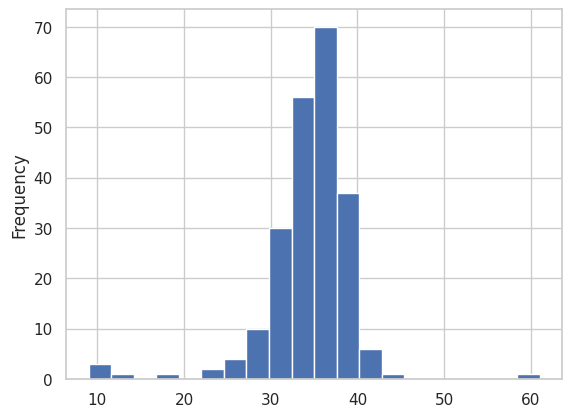

In [18]:
#Frecuency of frecuencies
freq_freq_keywords=pd.Series(frequency_keywords.values)
freq_freq_keywords.plot.hist(bins=20)

In [19]:
#Some stats 
freq_freq_keywords.describe()

count                 222.00
mean                   34.29
std                     5.10
min                     9.00
25%                    33.00
50%                    35.00
75%                    37.00
max                    61.00
dtype: float64

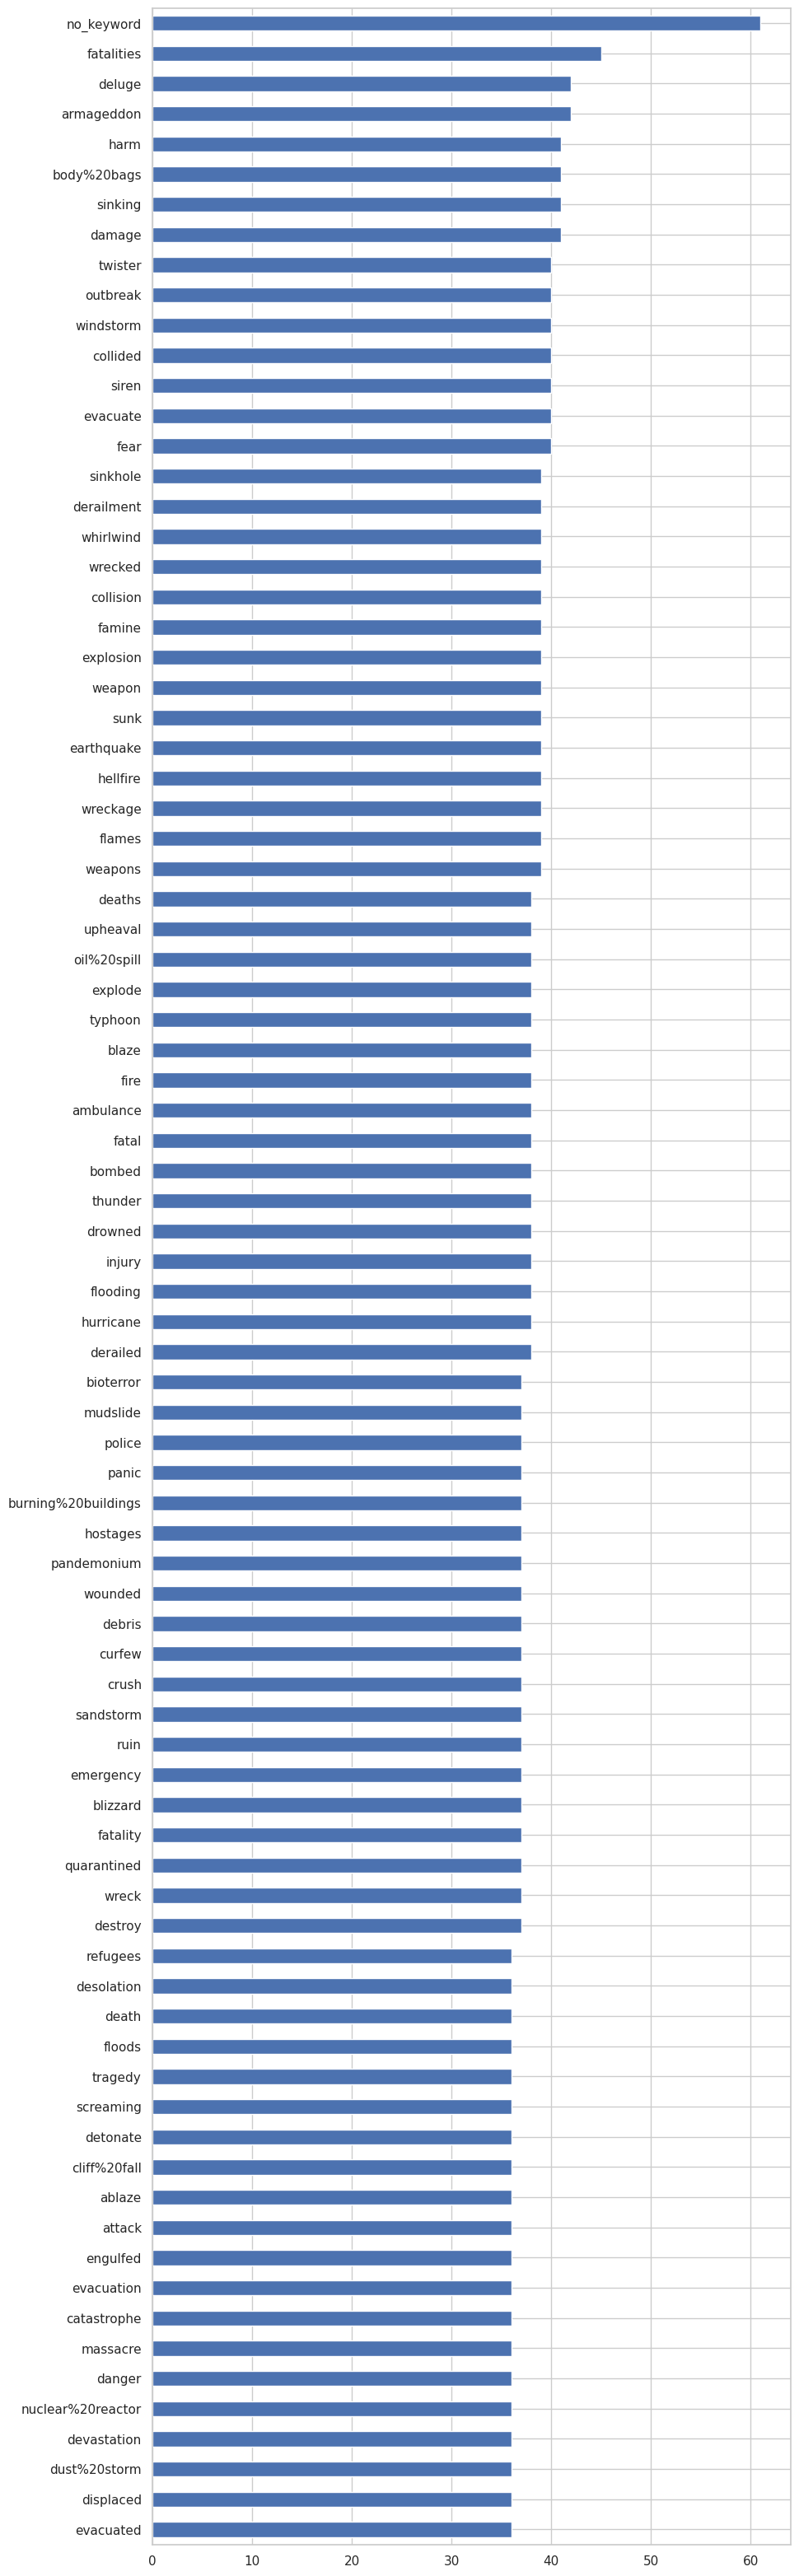

In [20]:
# Plotting keywords values counts up 35 repetitions. 
frequency_keywords[frequency_keywords>35].sort_values(ascending=True).plot(kind='barh', figsize=(10,40))

In [21]:
most_freq_keywords=frequency_keywords[frequency_keywords>35].index
most_freq_keywords

Index(['no_keyword', 'fatalities', 'deluge', 'armageddon', 'harm',
       'body%20bags', 'sinking', 'damage', 'fear', 'evacuate', 'siren',
       'twister', 'collided', 'windstorm', 'outbreak', 'flames', 'wreckage',
       'hellfire', 'earthquake', 'weapon', 'weapons', 'sunk', 'sinkhole',
       'explosion', 'famine', 'collision', 'wrecked', 'whirlwind',
       'derailment', 'bombed', 'fatal', 'blaze', 'ambulance', 'fire', 'deaths',
       'typhoon', 'explode', 'oil%20spill', 'upheaval', 'drowned', 'thunder',
       'injury', 'derailed', 'flooding', 'hurricane', 'fatality', 'emergency',
       'blizzard', 'sandstorm', 'quarantined', 'wreck', 'destroy', 'ruin',
       'crush', 'mudslide', 'debris', 'curfew', 'wounded', 'pandemonium',
       'hostages', 'burning%20buildings', 'panic', 'bioterror', 'police',
       'displaced', 'dust%20storm', 'devastation', 'nuclear%20reactor',
       'danger', 'massacre', 'catastrophe', 'evacuation', 'engulfed',
       'refugees', 'ablaze', 'cliff%20fal

In [22]:
keyword_target_df=df[['keyword','target']]
keyword_target_df.count()

keyword    7613
target     7613
dtype: int64

In [23]:
keyword_target_most_freq=keyword_target_df[keyword_target_df.loc[:,'keyword'].isin(most_freq_keywords)]
keyword_target_most_freq.count()

keyword    3211
target     3211
dtype: int64

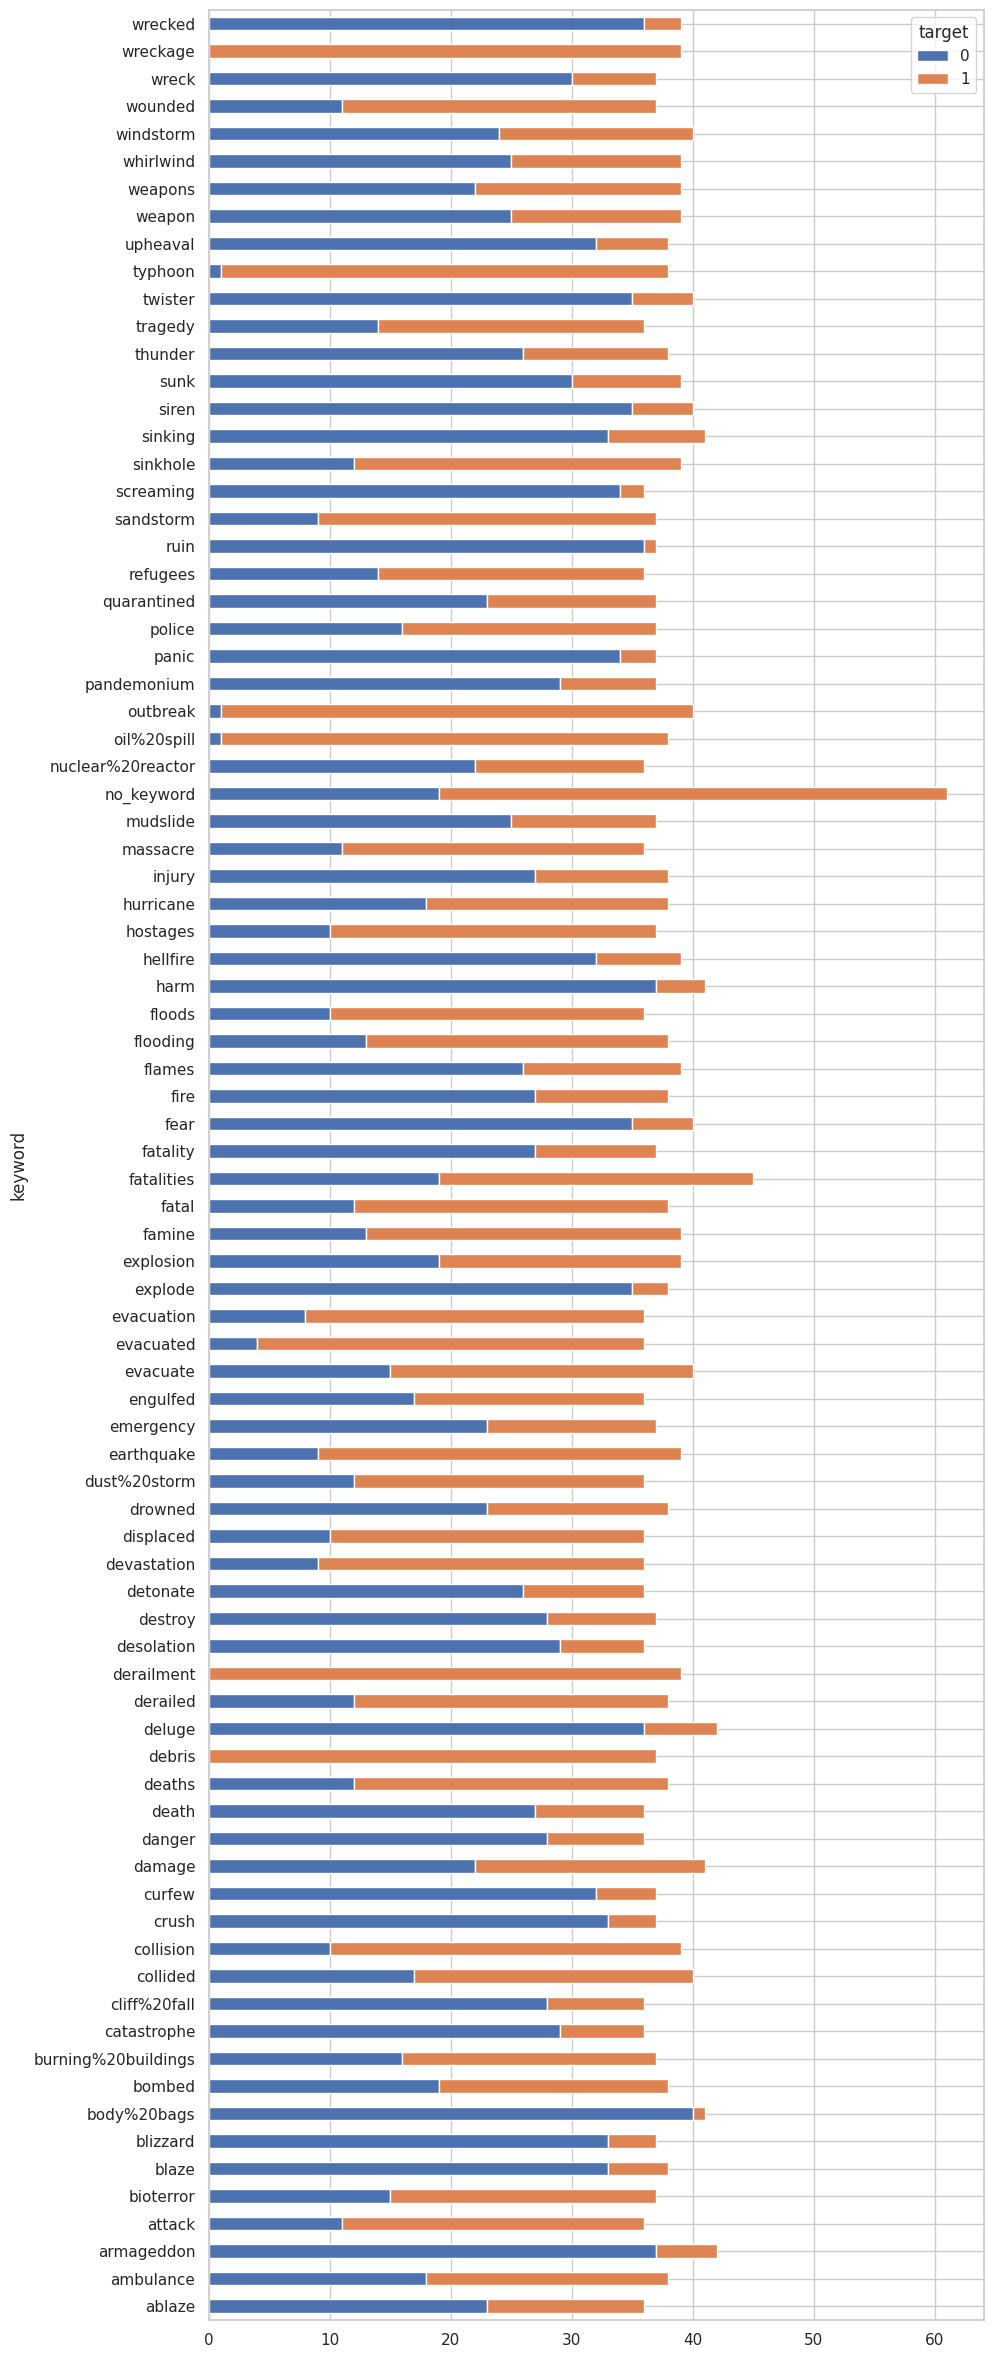

In [24]:
#Plotting Crosstab with the keywords that has a frequency more than 35. 
pd.crosstab(keyword_target_most_freq.keyword, keyword_target_most_freq.target).plot.barh(stacked=True, figsize=(10,30))

In [25]:
print('Top keywords in disaster tweets:')
print(df[df['target'] == 1]['keyword'].value_counts().head(), '\n')
print('Top keywords in non-disaster tweets:')
print(df[df['target'] == 0]['keyword'].value_counts().head())

Top keywords in disaster tweets:
no_keyword    42
derailment    39
wreckage      39
outbreak      39
typhoon       37
Name: keyword, dtype: int64 

Top keywords in non-disaster tweets:
body%20bags    40
armageddon     37
harm           37
deluge         36
wrecked        36
Name: keyword, dtype: int64


In [0]:
keyword_target_crosstab=pd.crosstab(df.keyword, df.target)

In [0]:
level0=keyword_target_crosstab.columns.get_level_values(0)

In [28]:
keyword_target_noindex=keyword_target_crosstab.reset_index()
keyword_target_noindex.columns=['keyword','target_0','target_1']
keyword_target_noindex.sort_values(by=['target_1'],ascending=False)

,keyword,target_0,target_1
147,no_keyword,19,42
154,outbreak,1,39
70,derailment,0,39
220,wreckage,0,39
206,typhoon,1,37
...,...,...,...
27,body%20bag,32,1
88,electrocute,31,1
29,body%20bags,40,1
171,ruin,36,1


In [0]:
keyword_target_noindex['percentage']=100*(keyword_target_noindex['target_1'])/((keyword_target_noindex['target_1'])+(keyword_target_noindex['target_0']))

In [0]:
keyword_target_noindex['count']=(keyword_target_noindex['target_1'])+(keyword_target_noindex['target_0'])

In [31]:
keyword_target_noindex.sort_values(by=['percentage'],ascending=False).head(20)

,keyword,target_0,target_1,percentage,count
220,wreckage,0,39,100.00,39
70,derailment,0,39,100.00,39
62,debris,0,37,100.00,37
154,outbreak,1,39,97.50,40
206,typhoon,1,37,97.37,38
153,oil%20spill,1,37,97.37,38
188,suicide%20bombing,1,32,96.97,33
187,suicide%20bomber,1,30,96.77,31
32,bombing,2,27,93.10,29
186,suicide%20bomb,3,32,91.43,35


In [32]:
#Calculating the number of keyword that contains '%20' over the total. 
round(100*(keyword_target_noindex[keyword_target_noindex['keyword'].str.contains('%20')]['keyword'].count())/(keyword_target_noindex['keyword'].count()),2)

16.22

## Looking at 'text'

### Analizing 'tweet_len'

#### Before dropping stopwords



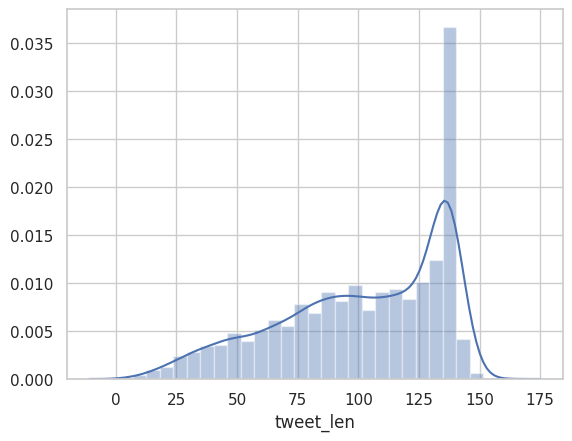

In [33]:
df['tweet_len']=df['text'].apply(lambda x: len(x))
sns.distplot(df["tweet_len"], hist=True)

In [34]:
#Tweets_len stats
df['tweet_len'].describe()

count               7,613.00
mean                  101.04
std                    33.78
min                     7.00
25%                    78.00
50%                   107.00
75%                   133.00
max                   157.00
Name: tweet_len, dtype: float64

In [35]:
#how many exactly are above the average length?
print(round(100.00*(df[(df['tweet_len'])>(df['tweet_len']).mean()]['tweet_len'].count())/(len(df['tweet_len'])),2),'% of the tweets have a length superior to the avg')

54.39 % of the tweets have a length superior to the avg


In [36]:
#That's why is right skewed
df['tweet_len'].skew()

-0.6190089979526021

In [37]:
#Calculating the mode
df['tweet_len'].mode()

0    136
dtype: int64

In [38]:
df['tweet_len_37.5']=np.where(df['tweet_len']<=37.5,1,0)
df['tweet_len_37.5'].value_counts()

0    7214
1     399
Name: tweet_len_37.5, dtype: int64

In [39]:
df['tweet_len_37.5_and_75']=np.where((df['tweet_len']>37.5) & (df['tweet_len']<=75),1,0)
df['tweet_len_37.5_and_75'].value_counts()

0    6224
1    1389
Name: tweet_len_37.5_and_75, dtype: int64

In [40]:
df['tweet_len_75_and_112.5']=np.where((df['tweet_len']>75) & (df['tweet_len']<=112.5),1,0)
df['tweet_len_75_and_112.5'].value_counts()

0    5244
1    2369
Name: tweet_len_75_and_112.5, dtype: int64

In [41]:
df['tweet_len_up112.5']=np.where(df['tweet_len']>112.5,1,0)
df['tweet_len_up112.5'].value_counts()

0    4157
1    3456
Name: tweet_len_up112.5, dtype: int64

In [0]:
grouped=df.groupby('target').agg({'tweet_len_37.5':['mean'], 'tweet_len_37.5_and_75':['mean'],\
                                'tweet_len_75_and_112.5':['mean'], 'tweet_len_up112.5':['mean']})

In [0]:
level_0=grouped.columns.get_level_values(0)

In [0]:
grouped.columns=level_0

In [45]:
grouped_for_barchart=grouped*100
grouped_for_barchart

,tweet_len_37.5,tweet_len_37.5_and_75,tweet_len_75_and_112.5,tweet_len_up112.5
target,,,,
0,7.60,22.50,29.39,40.51
1,2.11,12.60,33.41,51.88


In [46]:
grouped_for_barchart=grouped_for_barchart.stack().unstack(0)
grouped_for_barchart

target,0,1
tweet_len_37.5,7.60,2.11
tweet_len_37.5_and_75,22.50,12.60
tweet_len_75_and_112.5,29.39,33.41
tweet_len_up112.5,40.51,51.88


In [47]:
target0=grouped_for_barchart.iloc[:,0]
target0

tweet_len_37.5                           7.60
tweet_len_37.5_and_75                   22.50
tweet_len_75_and_112.5                  29.39
tweet_len_up112.5                       40.51
Name: 0, dtype: float64

In [48]:
target1=grouped_for_barchart.iloc[:,1]
target1

tweet_len_37.5                           2.11
tweet_len_37.5_and_75                   12.60
tweet_len_75_and_112.5                  33.41
tweet_len_up112.5                       51.88
Name: 1, dtype: float64

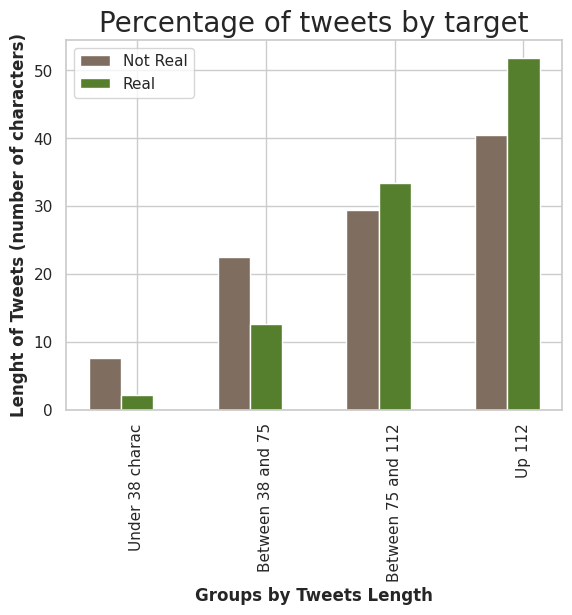

In [49]:
#Plotting bar chart

# Setting width of bar
barWidth = 0.25

# Setting position of bar on X axis
p0 = np.arange(len(target0))
p1 = [x + barWidth for x in p0] 

# Making the plot
plt.bar(p0, target0, color='#7f6d5f', width=barWidth, edgecolor='white', label='Not Real')
plt.bar(p1, target1, color='#557f2d', width=barWidth, edgecolor='white', label='Real')

# Setting ticks and labels of axes
plt.xlabel('Groups by Tweets Length', fontweight='bold')
plt.ylabel('Lenght of Tweets (number of characters)',fontweight='bold')
plt.xticks([r + barWidth for r in range(len(target0))], ['Under 38 charac', 'Between 38 and 75', 'Between 75 and 112', 'Up 112'],rotation='vertical')

# Setting title. 
plt.title('Percentage of tweets by target',fontsize =20)

# Create legend & Show graphic
plt.legend()
plt.show()

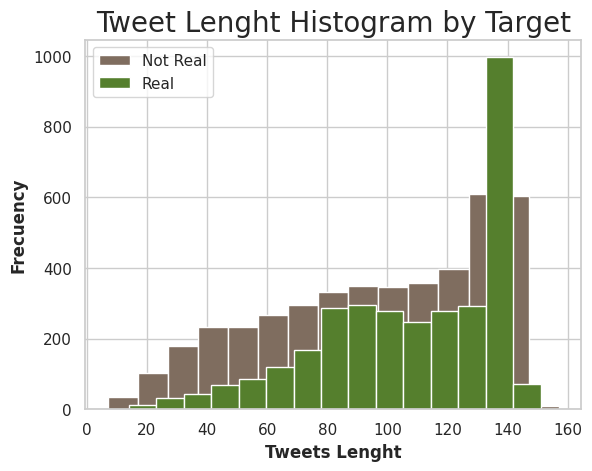

In [50]:
#Plotting histogram

# Making the plot
plt.hist(df[df['target']==0]['tweet_len'], color='#7f6d5f', label='Not Real', bins=15)
plt.hist(df[df['target']==1]['tweet_len'], color='#557f2d', label='Real', bins=15)

# Setting ticks and labels of axes
plt.xlabel('Tweets Lenght', fontweight='bold')
plt.ylabel('Frecuency',fontweight='bold')

# Setting title. 
plt.title('Tweet Lenght Histogram by Target',fontsize =20)

# Create legend & Show graphic
plt.legend()
plt.show()

In [51]:
#Playing with tweet length intervals and the target variable. 
for a,b in zip([120,125,130,135,140],[140,145,150,155,160]): 
  print('Tweet Lenght Range from',a,'to',b,':\n')
  print('the amount of tweets in this range is: ', df.loc[(df['tweet_len']>a) & (df['tweet_len']<b),'target'].value_counts().sum())
  print('The value_counts is:\n',df.loc[(df['tweet_len']>a) &(df['tweet_len']<b),'target'].value_counts())
  print("-" * 75)

Tweet Lenght Range from 120 to 140 :

the amount of tweets in this range is:  2495
The value_counts is:
 0    1254
1    1241
Name: target, dtype: int64
---------------------------------------------------------------------------
Tweet Lenght Range from 125 to 145 :

the amount of tweets in this range is:  2539
The value_counts is:
 1    1294
0    1245
Name: target, dtype: int64
---------------------------------------------------------------------------
Tweet Lenght Range from 130 to 150 :

the amount of tweets in this range is:  2182
The value_counts is:
 1    1142
0    1040
Name: target, dtype: int64
---------------------------------------------------------------------------
Tweet Lenght Range from 135 to 155 :

the amount of tweets in this range is:  1562
The value_counts is:
 1    826
0    736
Name: target, dtype: int64
---------------------------------------------------------------------------
Tweet Lenght Range from 140 to 160 :

the amount of tweets in this range is:  203
The valu

### Analizing the words before dropping stopwords


#### Transforming text to a list of words


In [52]:
#Getting a serie cointaining in each row the list of words of each tweet
df['list_words']=df['text'].apply(lambda x: x.split())
df['list_words']

0       [Our, Deeds, are, the, Reason, of, this, #eart...
1          [Forest, fire, near, La, Ronge, Sask., Canada]
2       [All, residents, asked, to, 'shelter, in, plac...
3       [13,000, people, receive, #wildfires, evacuati...
4       [Just, got, sent, this, photo, from, Ruby, #Al...
                              ...                        
7608    [Two, giant, cranes, holding, a, bridge, colla...
7609    [@aria_ahrary, @TheTawniest, The, out, of, con...
7610    [M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...
7611    [Police, investigating, after, an, e-bike, col...
7612    [The, Latest:, More, Homes, Razed, by, Norther...
Name: list_words, Length: 7613, dtype: object

#### Counting the words of each 'list_words'

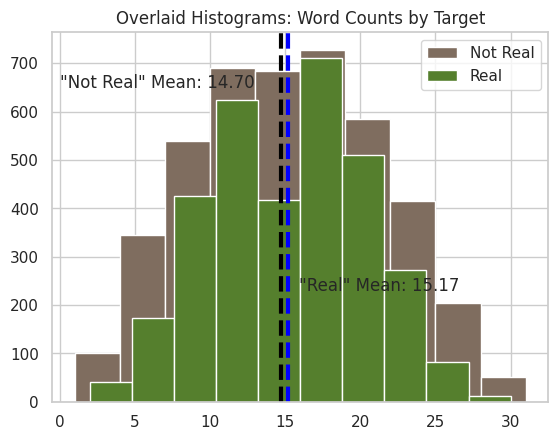

In [53]:
df['words_count']=df['list_words'].apply(lambda x: len(x))

#Plotting two histograms
plt.hist(df[df['target']==0]['words_count'], color='#7f6d5f', label='Not Real', bins=10)
plt.hist(df[df['target']==1]['words_count'], color='#557f2d', label='Real', bins=10)

#Plotting x_lines for means
plt.axvline(df[df['target']==0]['words_count'].mean(), color='black', linestyle='dashed', linewidth=3)
plt.axvline(df[df['target']==1]['words_count'].mean(), color='blue', linestyle='dashed', linewidth=3)

#Plotting text
min_ylim, max_ylim = plt.ylim()
plt.text(df[df['target']==0]['words_count'].mean()*(0.00), max_ylim*0.85, '"Not Real" Mean: {:.2f}'.format(df[df['target']==0]['words_count'].mean()))
plt.text(df[df['target']==1]['words_count'].mean()*1.05, max_ylim*0.3, '"Real" Mean: {:.2f}'.format(df[df['target']==1]['words_count'].mean()))

plt.title('Overlaid Histograms: Word Counts by Target')

plt.legend()
plt.show()

In [54]:
#T-test for words_count
from scipy import stats

stats.ttest_ind(df[df['target']==0]['words_count'],df[df['target']==1]['words_count'],equal_var=False)

Ttest_indResult(statistic=-3.5827341440382523, pvalue=0.0003421596979870606)

#### Number of character per word. 

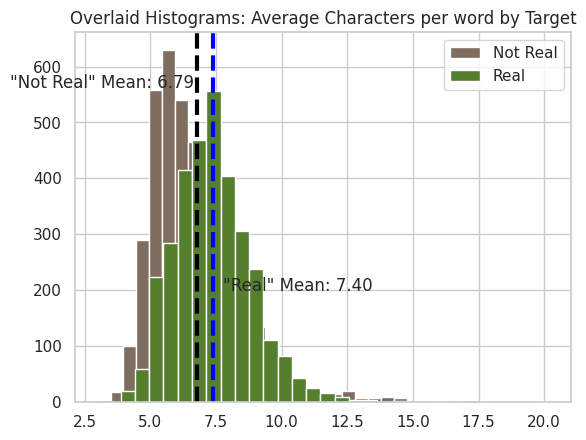

In [55]:
df['avg_characters_per_word']=df['tweet_len']/df['words_count']

#Plotting both hist together
plt.hist(df[df['target']==0]['avg_characters_per_word'], color='#7f6d5f', label='Not Real', bins=30)
plt.hist(df[df['target']==1]['avg_characters_per_word'], color='#557f2d', label='Real', bins=30)

#plotting avg lines. 
plt.axvline(df[df['target']==0]['avg_characters_per_word'].mean(), color='black', linestyle='dashed', linewidth=3)
plt.axvline(df[df['target']==1]['avg_characters_per_word'].mean(), color='blue', linestyle='dashed', linewidth=3)

#Plotting text
min_ylim, max_ylim = plt.ylim()
plt.text(df[df['target']==0]['avg_characters_per_word'].mean()*(-0.05), max_ylim*0.85,\
         '"Not Real" Mean: {:.2f}'.format(df[df['target']==0]['avg_characters_per_word'].mean()))
plt.text(df[df['target']==1]['avg_characters_per_word'].mean()*1.05, max_ylim*0.3, \
         '"Real" Mean: {:.2f}'.format(df[df['target']==1]['avg_characters_per_word'].mean()))

plt.title('Overlaid Histograms: Average Characters per word by Target')


plt.legend()
plt.show()

In [56]:
#T-test for avg_characters_per_word
stats.ttest_ind(df[df['target']==0]['avg_characters_per_word'],df[df['target']==1]['avg_characters_per_word'],equal_var=False)

Ttest_indResult(statistic=-16.507057390104332, pvalue=3.7846040039667963e-60)

Although it no means that `woirds_count` and `avg_characters_per_word` are good predictor or not, it's important having statistical significance in the means difference test 

#### Hashtags

In [77]:
text_df=df[['list_words','words_count','target','keyword']]
text_df.head()

,list_words,words_count,target,keyword
0,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,1,no_keyword
1,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,1,no_keyword
2,"[All, residents, asked, to, 'shelter, in, plac...",22,1,no_keyword
3,"[13,000, people, receive, #wildfires, evacuati...",8,1,no_keyword
4,"[Just, got, sent, this, photo, from, Ruby, #Al...",16,1,no_keyword


In [0]:
#Defining a function that returns a list of hashtags or empty list

def has_hashtags(list_of_words):
  i=0
  hashtags=[]
  while i<len(list_of_words): 
    if '#' in list_of_words[i]:
        word=list(list_of_words[i])
        word=word[1:]
        word=''.join(map(str, word))
        hashtags.append(word)
    
    i=i+1
  return hashtags
    


In [79]:
text_df['hashtags']=df['list_words'].apply(has_hashtags)
text_df

,list_words,words_count,target,keyword,hashtags
0,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,1,no_keyword,[earthquake]
1,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,1,no_keyword,[]
2,"[All, residents, asked, to, 'shelter, in, plac...",22,1,no_keyword,[]
3,"[13,000, people, receive, #wildfires, evacuati...",8,1,no_keyword,[wildfires]
4,"[Just, got, sent, this, photo, from, Ruby, #Al...",16,1,no_keyword,"[Alaska, wildfires]"
...,...,...,...,...,...
7608,"[Two, giant, cranes, holding, a, bridge, colla...",11,1,no_keyword,[]
7609,"[@aria_ahrary, @TheTawniest, The, out, of, con...",20,1,no_keyword,[]
7610,"[M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...",8,1,no_keyword,[]
7611,"[Police, investigating, after, an, e-bike, col...",19,1,no_keyword,[]


Once we get a column with a list of hashtags per row it's possible to make some calculus related with this task:

  -Number of hashtags per row

  -Top 20 of used hashtags

  -Relationships between hashtags and keyword

  -Analyzing the rows with empty list in the hashtag column

##### Number of hashtags per row


In [0]:
text_df['number_of_hashtags'] = text_df['hashtags'].apply(lambda x: len(x)) 

In [81]:
text_df[text_df['target']==1]['number_of_hashtags'].value_counts(normalize=True)*100.00

0                   73.25
1                   14.89
2                    6.14
3                    2.97
4                    1.19
5                    0.67
10                   0.21
8                    0.21
6                    0.21
13                   0.12
7                    0.12
Name: number_of_hashtags, dtype: float64

In [82]:
text_df[text_df['target']==0]['number_of_hashtags'].value_counts(normalize=True)*100.00

0                   79.59
1                   11.19
2                    4.61
3                    2.46
4                    1.06
6                    0.41
5                    0.39
7                    0.09
10                   0.07
11                   0.05
9                    0.05
8                    0.02
Name: number_of_hashtags, dtype: float64

Text(0.5, 1.0, 'Overlaid Density Plot: Number of hashtags by target for number_of_hashtags>0')

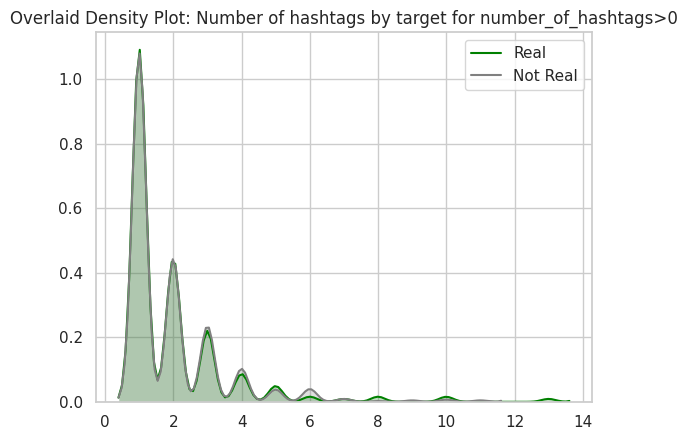

In [83]:
#Plotting the number of hashtags by target for number_of_hashtags>0
sns.kdeplot(text_df[(text_df['target']==1) & (text_df['number_of_hashtags']>0)]['number_of_hashtags'], color='green', label='Real', shade=True)
sns.kdeplot(text_df[(text_df['target']==0) & (text_df['number_of_hashtags']>0)]['number_of_hashtags'], color='grey', label='Not Real', shade=True)  
plt.title('Overlaid Density Plot: Number of hashtags by target for number_of_hashtags>0')

##### Top 20 used hashtags (don't do it yet)


##### Relationships between keyword and hashtag

Is the `keyword` in the `hashtag` column? (under construction)

In [0]:
#Creating a function that returns a binary list of ones or zero if meets the condition or not and the position of the keyword in the list of hashtags. 
def func(valueA, listB):
    new_list = []
    for i in range(len(listB)): 
        if listB[i] == valueA:
            new_list.append(1)
        else:
            new_list.append(0)
    return new_list

In [86]:
#Creating a new column of binary lists that indicates if the keyword is in the hashtags
text_df['keyword_in_hashtag']=text_df.apply(lambda x: func(x.keyword,x.hashtags), axis=1)
text_df

,list_words,words_count,target,keyword,hashtags,number_of_hashtags,keyword_in_hashtag
0,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,1,no_keyword,[earthquake],1,[0]
1,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,1,no_keyword,[],0,[]
2,"[All, residents, asked, to, 'shelter, in, plac...",22,1,no_keyword,[],0,[]
3,"[13,000, people, receive, #wildfires, evacuati...",8,1,no_keyword,[wildfires],1,[0]
4,"[Just, got, sent, this, photo, from, Ruby, #Al...",16,1,no_keyword,"[Alaska, wildfires]",2,"[0, 0]"
...,...,...,...,...,...,...,...
7608,"[Two, giant, cranes, holding, a, bridge, colla...",11,1,no_keyword,[],0,[]
7609,"[@aria_ahrary, @TheTawniest, The, out, of, con...",20,1,no_keyword,[],0,[]
7610,"[M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...",8,1,no_keyword,[],0,[]
7611,"[Police, investigating, after, an, e-bike, col...",19,1,no_keyword,[],0,[]


In [111]:
#Getting a subset with keyword!='no_keyword' and keyword_in_hashtag!=[]
text_df[(text_df.apply(lambda x: x.keyword_in_hashtag!=[], axis=1)) & (text_df.loc[:,'keyword']!='no_keyword')]

,list_words,words_count,target,keyword,hashtags,number_of_hashtags,keyword_in_hashtag
32,"[We, always, try, to, bring, the, heavy., #met...",10,0,ablaze,"[metal, RT]",2,"[0, 0]"
33,"[#AFRICANBAZE:, Breaking, news:Nigeria, flag, ...",9,1,ablaze,[AFRICANBAZE:],1,[0]
36,"[@PhDSquares, #mufc, they've, built, so, much,...",21,0,ablaze,[mufc],1,[0]
38,"[Barbados, #Bridgetown, JAMAICA, ÛÒ, Two, car...",19,1,ablaze,[Bridgetown],1,[0]
40,"[Check, these, out:, http://t.co/rOI2NSmEJJ, h...",8,0,ablaze,[nsfw],1,[0]
...,...,...,...,...,...,...,...
7554,"[James, Kunstler:, How, bad, architecture, wre...",11,0,wrecked,"[residualincome, mlm]",2,"[0, 0]"
7558,"[coleslaw, #wrecked, http://t.co/sijNBmCZIJ]",3,0,wrecked,[wrecked],1,[1]
7570,"[Cramer:, Iger's, 3, words, that, wrecked, Dis...",11,0,wrecked,"[cnbc, topnews]",2,"[0, 0]"
7577,"[@widda16, ..., He's, gone., You, can, relax.,...",21,0,wrecked,[whoops],1,[0]


In [112]:
#It's a subset of 1740 rows. 
len(text_df[(text_df.apply(lambda x: x.keyword_in_hashtag!=[], axis=1)) & (text_df.loc[:,'keyword']!='no_keyword')])

1740

In [137]:
#A subset with keyword in hashtag
text_df[text_df.apply(lambda x: sum(x.keyword_in_hashtag)==1, axis=1)]

,list_words,words_count,target,keyword,hashtags,number_of_hashtags,keyword_in_hashtag
122,"[That, moment, when, you, get, on, a, scary, r...",23,0,aftershock,"[silverwood, aftershock]",2,"[0, 1]"
189,"[EMS1:, NY, EMTs, petition, for, $17, per, hou...",14,0,ambulance,"[ems, paramedics, ambulance]",3,"[0, 0, 1]"
612,"[#anthrax, #bioterrorism, CDC, To, Carry, Out,...",16,1,bioterrorism,"[anthrax, bioterrorism]",2,"[0, 1]"
616,"[A, Tale, of, Two, Pox, -, Body, Horrors, http...",12,1,bioterrorism,"[virus, infectiousdiseases, bioterrorism]",3,"[0, 0, 1]"
639,"[#bioterrorism, Authorities, allay, #glanders,...",15,1,bioterrorism,"[bioterrorism, glanders]",2,"[1, 0]"
...,...,...,...,...,...,...,...
7280,"[Feel, like, I've, got, no, control, of, anyth...",19,1,whirlwind,"[whirlwind, drained]",2,"[1, 0]"
7340,"[Dr., Bengston, on, #wildfire, management:, Û...",22,1,wildfire,"[wildfire, smem]",2,"[1, 0]"
7350,"[This, machine, really, captured, my, attentio...",12,1,wildfire,"[helicopter, firefighting, wildfire, oregon, e...",5,"[0, 0, 1, 0, 0]"
7357,"[#California, #wildfire, destroys, more, homes...",10,1,wildfire,"[California, wildfire]",2,"[0, 1]"


In [144]:
#has only 76 rows and 44 of them are target = 1
print('This subset has ',len(text_df[text_df.apply(lambda x: sum(x.keyword_in_hashtag)==1, axis=1)]),'rows')
print(('-')*75)
print('The value counts of target is \n',text_df[text_df.apply(lambda x: sum(x.keyword_in_hashtag)==1, axis=1)]['target'].value_counts())
print(('-')*75)

This subset has  76 rows
---------------------------------------------------------------------------
The value counts of target is 
 1    44
0    32
Name: target, dtype: int64
---------------------------------------------------------------------------


In [149]:
text_df['bool_key_in_hash']=text_df.apply(lambda x: sum(x.keyword_in_hashtag)==1, axis=1)
text_df

,list_words,words_count,target,keyword,hashtags,number_of_hashtags,keyword_in_hashtag,sum_key_in_hash,bool_key_in_hash
0,"[Our, Deeds, are, the, Reason, of, this, #eart...",13,1,no_keyword,[earthquake],1,[0],False,False
1,"[Forest, fire, near, La, Ronge, Sask., Canada]",7,1,no_keyword,[],0,[],False,False
2,"[All, residents, asked, to, 'shelter, in, plac...",22,1,no_keyword,[],0,[],False,False
3,"[13,000, people, receive, #wildfires, evacuati...",8,1,no_keyword,[wildfires],1,[0],False,False
4,"[Just, got, sent, this, photo, from, Ruby, #Al...",16,1,no_keyword,"[Alaska, wildfires]",2,"[0, 0]",False,False
...,...,...,...,...,...,...,...,...,...
7608,"[Two, giant, cranes, holding, a, bridge, colla...",11,1,no_keyword,[],0,[],False,False
7609,"[@aria_ahrary, @TheTawniest, The, out, of, con...",20,1,no_keyword,[],0,[],False,False
7610,"[M1.94, [01:04, UTC]?5km, S, of, Volcano, Hawa...",8,1,no_keyword,[],0,[],False,False
7611,"[Police, investigating, after, an, e-bike, col...",19,1,no_keyword,[],0,[],False,False


In [155]:
#Correlation 
text_df[['target','bool_key_in_hash']].corr()

,target,bool_key_in_hash
target,1.00,0.03
bool_key_in_hash,0.03,1.00


#### Polarity


In [0]:
tweet_sample=df.text.sample(1).iloc[0]
print(tweet_sample)

In [0]:
from textblob import TextBlob

In [0]:
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity


df['polarity']=df['text'].apply(detect_polarity)

In [0]:
df['polarity'].describe()

In [0]:
df['polarity'].plot(kind='kde')
plt.title('Density plot: Polarity of tweets text without cleanning')

#### Subjectivity

In [0]:
def detect_subjectivity(text): 
  return TextBlob(text).sentiment.subjectivity

df['subjectivity']=df['text'].apply(detect_subjectivity)

In [0]:
df['subjectivity'].describe()

In [0]:
df['subjectivity'].plot(kind='kde')
plt.title('Density Plot: Subjectivity of Tweets Text')